<p style="font-weight:bold;font-size:200%">完整数据集分析</p>

- Author: Yichen Luo
- Date: 2022/06/26

- 宏观因子分布都特别奇怪
- 八个宏观因子已经Normalize过了么，如果已经处理了交乘项会不会重复Normalize
- 指数不是线性的
- 再次确定一下时间

In [38]:
import os
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline

RD = "/home/team_crypto/2022_crypto_ml/02_rdata/"
WD = "/home/team_crypto/2022_crypto_ml/03_wdata/"
RES = "/home/team_crypto/2022_crypto_ml/04_result/"

In [39]:
def winsor(x: pd.Series, cut=[0.01, 0.99]) -> pd.Series:
    x = x.copy()
    lb = x.quantile(cut[0])
    ub = x.quantile(cut[1])
    x[x < lb] = lb
    x[x > ub] = ub
    return x

# 数据预处理

In [40]:
df = pd.read_parquet(f'{WD}1205_cypto_macro.pq')
df.drop(columns=['prc_i', 'prc_j'], inplace=True)
df.shape
df.head(3)

(240380, 51)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxdprc,size_age,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud,vol_beta,vol_idiovol,vol_delay,vol_beta2,macro_hash,macro_trend,macro_dp,macro_ep,macro_b/m,macro_ntis,macro_tbl,macro_tms,macro_dfy,macro_svar
0,0chain,2018,29,2018-07-20,0.433,0.483,1.731e+07,78317.054,92248.917,19702.629,173167.480,-0.104,-0.104,NaN,zcn,0chain,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.813e+07,16.000,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009,6.229e-04
1,0chain,2018,30,2018-07-27,0.350,0.392,1.400e+07,86598.506,52531.013,45700.104,233272.948,-0.029,0.046,0.050,zcn,0chain,5,16.667,0.36,0.483,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.062,11.269,0.005,NaN,-0.104,9.889,1.334e-06,NaN,NaN,NaN,NaN,3.964e+07,16.000,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009,6.229e-04
2,0chain,2018,31,2018-08-03,0.248,0.386,9.908e+06,32032.128,34818.453,17801.753,102016.323,-0.046,0.099,0.079,zcn,0chain,5,16.455,0.30,0.392,14.0,-0.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.360,11.369,0.006,0.05,0.046,10.730,3.321e-07,NaN,NaN,NaN,NaN,4.299e+07,14.222,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009,6.229e-04


/home/yichen/miniconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

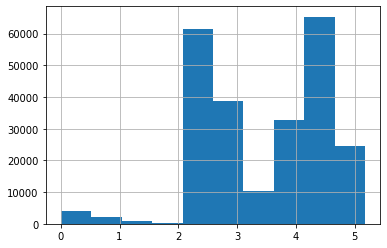

In [41]:
df.sort_values(['id', 'time'], ascending=True, inplace=True)

df['ret'] = df.groupby(['id'])['prices'].pct_change()
df['ln_ret'] = np.log(df['ret'] + 1)
df['macro_hash'] = np.log(df['macro_hash'])
df['macro_trend'] = np.log(df['macro_trend'])

df['macro_trend'].hist()

In [42]:
info_vars = ['id', 'year', 'week', 'time', 'symbol', 'name', 'day', 'prices']
ret_vars = ['ret', 'ln_ret']
wret_vars = [f'{x}_w' for x in ret_vars]

post_macro_vars = ['macro_dp', 'macro_ep', 'macro_b/m', 'macro_ntis', 'macro_tbl', 'macro_tms', 'macro_dfy']
pre_macro_vars = ['macro_hash', 'macro_trend', 'macro_svar']

post_w_macro_vars = [f'{x}_w' for x in post_macro_vars]

factor_vars = [x for x in df.columns if re.findall('size_|vol_|volume_|mom_', x)] + pre_macro_vars
wfactor_vars = [f'{x}_w' for x in factor_vars + post_macro_vars]

len(info_vars)
len(wret_vars)
len(wfactor_vars)

8

2

34

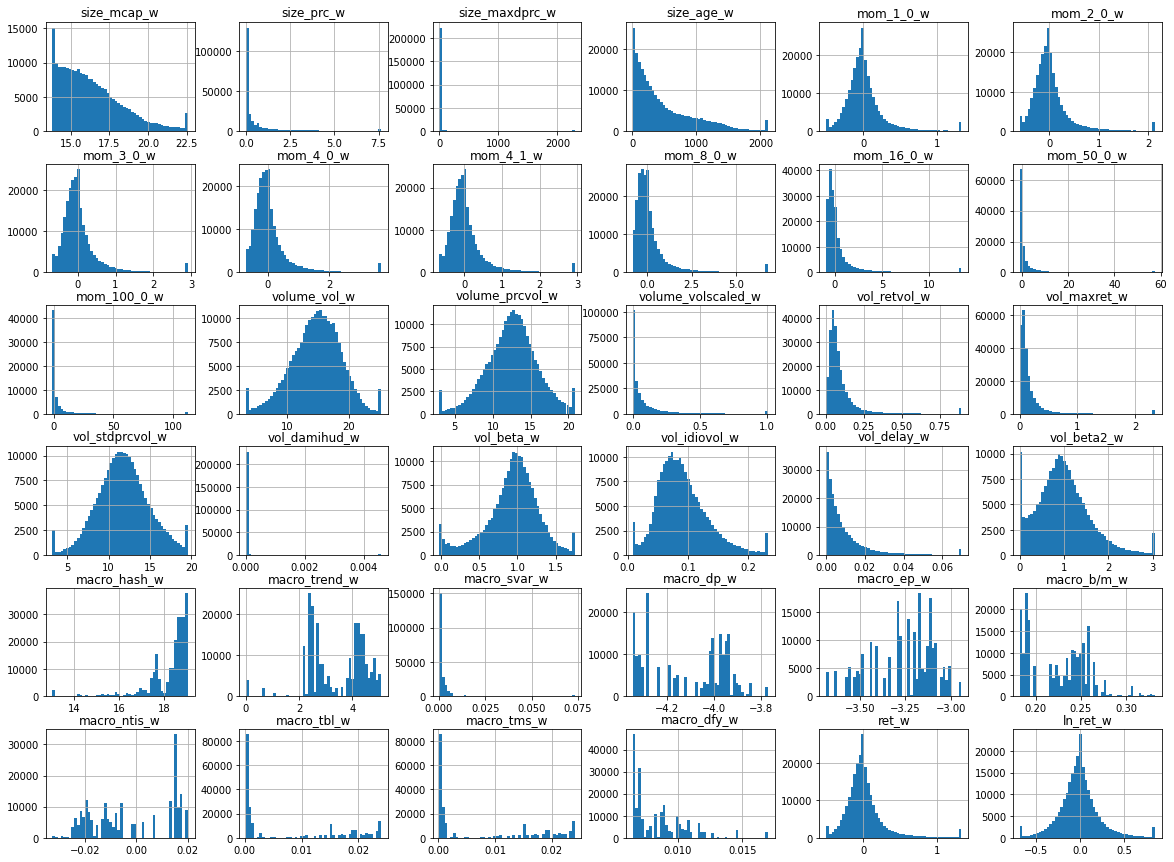

In [43]:
for var in [x for x in factor_vars + ret_vars]:
    df[f'{var}_w'] = winsor(df[var])

for var in post_macro_vars:
    df[f'{var}_w'] = df[var]
    
_ = df[wfactor_vars + wret_vars].hist(bins=50, figsize=(20, 15))

In [44]:
df2 = df.loc[:, info_vars + wret_vars + wfactor_vars]
df2.shape
df2.head(3)

(240380, 44)

,id,year,week,time,symbol,name,day,prices,ret_w,ln_ret_w,size_mcap_w,size_prc_w,size_maxdprc_w,size_age_w,mom_1_0_w,mom_2_0_w,mom_3_0_w,mom_4_0_w,mom_4_1_w,mom_8_0_w,mom_16_0_w,mom_50_0_w,mom_100_0_w,volume_vol_w,volume_prcvol_w,volume_volscaled_w,vol_retvol_w,vol_maxret_w,vol_stdprcvol_w,vol_damihud_w,vol_beta_w,vol_idiovol_w,vol_delay_w,vol_beta2_w,macro_hash_w,macro_trend_w,macro_svar_w,macro_dp_w,macro_ep_w,macro_b/m_w,macro_ntis_w,macro_tbl_w,macro_tms_w,macro_dfy_w
0,0chain,2018,29,2018-07-20,zcn,0chain,5,0.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.456,2.773,6.229e-04,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009
1,0chain,2018,30,2018-07-27,zcn,0chain,5,0.350,-0.191,-0.212,16.667,0.36,0.483,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.062,11.269,0.005,NaN,-0.003,9.889,1.334e-06,NaN,NaN,NaN,NaN,17.495,2.773,6.229e-04,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009
2,0chain,2018,31,2018-08-03,zcn,0chain,5,0.248,-0.292,-0.346,16.455,0.30,0.392,14.0,-0.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.360,11.369,0.006,0.05,0.046,10.730,3.321e-07,NaN,NaN,NaN,NaN,17.577,2.655,6.229e-04,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009


In [45]:
df2.to_parquet(f'{WD}1206_cypto_macro_processed.pq')

# 样本分割

In [46]:
df = pd.read_parquet(f'{WD}1206_cypto_macro_processed.pq')
df.shape
df.head(3)

(240380, 44)

,id,year,week,time,symbol,name,day,prices,ret_w,ln_ret_w,size_mcap_w,size_prc_w,size_maxdprc_w,size_age_w,mom_1_0_w,mom_2_0_w,mom_3_0_w,mom_4_0_w,mom_4_1_w,mom_8_0_w,mom_16_0_w,mom_50_0_w,mom_100_0_w,volume_vol_w,volume_prcvol_w,volume_volscaled_w,vol_retvol_w,vol_maxret_w,vol_stdprcvol_w,vol_damihud_w,vol_beta_w,vol_idiovol_w,vol_delay_w,vol_beta2_w,macro_hash_w,macro_trend_w,macro_svar_w,macro_dp_w,macro_ep_w,macro_b/m_w,macro_ntis_w,macro_tbl_w,macro_tms_w,macro_dfy_w
0,0chain,2018,29,2018-07-20,zcn,0chain,5,0.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.456,2.773,6.229e-04,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009
1,0chain,2018,30,2018-07-27,zcn,0chain,5,0.350,-0.191,-0.212,16.667,0.36,0.483,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.062,11.269,0.005,NaN,-0.003,9.889,1.334e-06,NaN,NaN,NaN,NaN,17.495,2.773,6.229e-04,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009
2,0chain,2018,31,2018-08-03,zcn,0chain,5,0.248,-0.292,-0.346,16.455,0.30,0.392,14.0,-0.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.360,11.369,0.006,0.05,0.046,10.730,3.321e-07,NaN,NaN,NaN,NaN,17.577,2.655,6.229e-04,-3.976,-3.1,0.258,-0.022,0.019,0.019,0.009


In [47]:
dfy = {y: df.loc[df['year'] == y].copy() for y in range(2015, 2023)}
dfy.keys()

dict_keys([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [48]:
specs = {}
for y in range(2016, 2020):
    train = pd.concat([dfy[y] for y in range(2016, y + 1)]).dropna(subset= wfactor_vars + wret_vars, how='any')
    valid = dfy[y + 1].dropna(subset= wfactor_vars + wret_vars, how='any')
    test = pd.concat([dfy[y] for y in range(y + 2, 2022)]).dropna(subset= wfactor_vars + wret_vars, how='any')
    specs[y] = {
        'train': train,
        'valid': valid,
        'test': test
    }

In [49]:
y = 2019
set(specs[y]['train']['year'])  # 得到最优的参数
set(specs[y]['valid']['year'])  # 得到最优的超参数
set(specs[y]['test']['year'])

{2016, 2017, 2018, 2019}

{2020}

{2021}

# 模型训练

## ElasticNet

In [50]:
from sklearn.linear_model import ElasticNet

In [169]:
def plot(res):
    y, x = list(zip(*res))
    plt.plot(x, y)
    plt.ylabel('$R_{Valid}^2$')
    plt.xlabel('ENet: $\\alpha$')
    plt.show()

In [56]:
pd.concat([df[[var for var in wfactor_vars if var not in post_w_macro_vars]], df[post_w_macro_vars]], axis=1)

,size_mcap_w,size_prc_w,size_maxdprc_w,size_age_w,mom_1_0_w,mom_2_0_w,mom_3_0_w,mom_4_0_w,mom_4_1_w,mom_8_0_w,mom_16_0_w,mom_50_0_w,mom_100_0_w,volume_vol_w,volume_prcvol_w,volume_volscaled_w,vol_retvol_w,vol_maxret_w,vol_stdprcvol_w,vol_damihud_w,vol_beta_w,vol_idiovol_w,vol_delay_w,vol_beta2_w,macro_hash_w,macro_trend_w,macro_svar_w,macro_dp_w,macro_ep_w,macro_b/m_w,macro_ntis_w,macro_tbl_w,macro_tms_w,macro_dfy_w
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.456,2.773,6.229e-04,-3.976,-3.100,0.258,-0.022,0.019,0.019,0.009
1,16.667,0.360,0.483,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.062,11.269,0.005,NaN,-0.003,9.889,1.334e-06,NaN,NaN,NaN,NaN,17.495,2.773,6.229e-04,-3.976,-3.100,0.258,-0.022,0.019,0.019,0.009
2,16.455,0.300,0.392,14.0,-0.191,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.360,11.369,0.006,0.050,0.046,10.730,3.321e-07,NaN,NaN,NaN,NaN,17.577,2.655,6.229e-04,-3.976,-3.100,0.258,-0.022,0.019,0.019,0.009
3,16.109,0.221,0.386,21.0,-0.292,-0.428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.533,10.375,0.003,0.079,0.099,9.787,1.422e-06,NaN,NaN,NaN,NaN,17.709,2.773,6.544e-04,-4.003,-3.114,0.246,-0.017,0.020,0.020,0.009
4,15.821,0.170,0.318,28.0,-0.250,-0.469,-0.571,NaN,NaN,NaN,NaN,NaN,NaN,13.249,11.786,0.018,0.181,0.358,11.527,2.112e-07,NaN,NaN,NaN,NaN,17.768,2.773,6.544e-04,-4.003,-3.114,0.246,-0.017,0.020,0.020,0.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240375,15.133,0.083,0.105,84.0,-0.147,-0.499,-0.215,-0.092,0.064,0.269,NaN,NaN,NaN,11.674,9.338,0.003,0.065,0.076,8.855,1.822e-06,1.061,0.171,0.044,1.125,18.966,4.337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240376,15.238,0.090,0.098,91.0,0.098,-0.064,-0.450,-0.138,-0.215,0.665,NaN,NaN,NaN,12.071,9.680,0.004,0.071,0.121,8.989,9.775e-07,0.970,0.165,0.039,0.940,19.054,4.186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240377,15.320,0.088,0.100,98.0,-0.030,0.066,-0.091,-0.466,-0.450,0.786,NaN,NaN,NaN,12.045,9.680,0.004,0.100,0.223,9.736,2.885e-08,1.046,0.160,0.036,1.094,19.043,4.159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
240378,14.963,0.062,0.088,105.0,-0.306,-0.326,-0.260,-0.369,-0.091,0.455,NaN,NaN,NaN,11.338,8.740,0.002,0.076,0.060,8.683,7.699e-06,1.061,0.156,0.028,1.126,19.043,4.072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
def gen_data(df, xvar, mvar, dvar=''):
    X = df[[var for var in (xvar + mvar) if var not in post_w_macro_vars]].copy()
    y = df['ret_w']
    if dvar: X[dvar] = 0
    for x in xvar:
        for m in mvar:
            X[f'{x}_{m}'] = X[x] * X[m]
    X = preprocessing.StandardScaler().fit(X).transform(X)
    X = pd.concat([X, df[post_w_macro_vars]], axis=1)
    return y, X

In [61]:
train, valid, test = specs[2019]
y_train, X_train = gen_data(train, wfactor_vars, '', '')
y_train
X_train

TypeError: can only concatenate list (not "str") to list

In [171]:
def run(year, xvar, mvar, dvar=''):
    # print(var, year)
    
    train, valid, test = specs[year].values()
    
    y_train, X_train = gen_data(train, xvar, mvar, dvar)
    y_valid, X_valid = gen_data(valid, xvar, mvar, dvar)
    y_test, X_test = gen_data(test, xvar, mvar, dvar)
    
    res = []
    for l in np.linspace(-4, -1, 50):
        regr = ElasticNet(alpha=10 ** l, l1_ratio=0.5, random_state=0)
        _ = regr.fit(X_train, y_train)
        s_valid = regr.score(X_valid, y_valid)
        res.append((s_valid, 10 ** l))
    
    # plot(res)
    
    _, alpha_opt = max(res)
    
    regr = ElasticNet(alpha=alpha_opt, l1_ratio=0.5, random_state=0)
    _ = regr.fit(X_train, y_train)
    s_train = regr.score(X_train, y_train)
    s_valid = regr.score(X_valid, y_valid)
    s_test = regr.score(X_test, y_test)
    
    test['ret_pred'] = regr.predict(X_test)
    
    test2 = test.set_index(['id', 'year', 'week']).loc[:, ['ret_w', 'ret_pred']]
    test2.to_parquet(f'{WD}0001_teaching/fitted/enet/{year}_{var}.pq')
    
    return 'enet', year, s_train, s_valid, s_test, var  # +hyperparameter

In [172]:
xvar = wfactor_vars
for var in [''] + xvar:
    summary = [run(year, xvar=xvar, mvar=var) for year in range(2017, 2021)]
    print(var)
    
    dfs = []
    for file in os.listdir(f'{WD}0001_teaching/fitted/enet/'):
        if (var not in file): continue
        dfs.append(pd.read_parquet(f'{WD}0001_teaching/fitted/enet/{file}'))
    dfs = pd.concat(dfs)
    
    r2 = 1 - sum((dfs['ret_w'] - dfs['ret_pred']) ** 2) / sum((dfs['ret_w']) ** 2)  # - dfs['ret_w'].mean()
    summary.append(['enet', 0, np.nan, np.nan, r2, var])
    
    res = pd.DataFrame(summary, columns=['model', 'year', 'r2_train', 'r2_valid', 'r2_test', 'drop_var'])
    res.to_csv(f'{WD}0001_teaching/r2/enet-r.csv', mode='a', index=False, header=False)

TypeError: can only concatenate list (not "str") to list